# Goals
Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

Estimate a bounding box for vehicles detected.


# Load data

In [1]:
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [2]:
def read_image(file_name):
    img = cv2.imread(file_name)
    return np.dstack((img[:, :, 2], img[:, :, 1], img[:, :, 0]))

In [3]:
X_files_name = []
Y = []
for root, dirs, files in os.walk("./data/non-vehicles/"):
    for file_name in files:
        if file_name.endswith(".png"):
            X_files_name.append(os.path.abspath(os.path.join(root, file_name)))
            Y.append(0)
for root, dirs, files in os.walk("./data/vehicles/"):
    for file_name in files:
        if file_name.endswith(".png"):
            X_files_name.append(os.path.abspath(os.path.join(root, file_name)))
            Y.append(1)
Y = np.array(Y)

In [4]:
X_files_name, Y = shuffle(X_files_name, Y)

In [5]:
print("Total number of samples: {}".format(len(Y)))
print("Positive samples: {}".format(sum(Y)))
print("Negative samples: {}".format(len(Y) - sum(Y)))

Total number of samples: 17760
Positive samples: 8792
Negative samples: 8968


In [6]:
X_train_files_name, X_test_files_name, Y_train, Y_test = train_test_split(X_files_name, Y, test_size=.2)

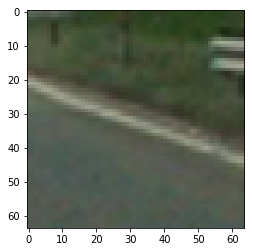

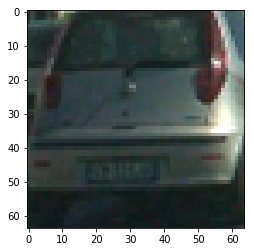

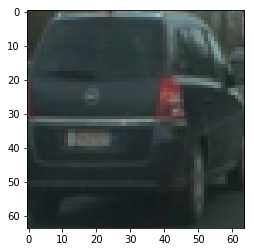

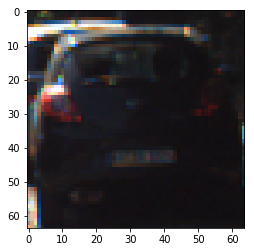

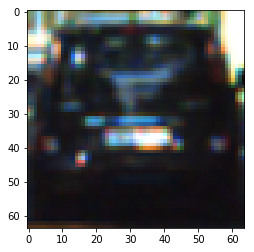

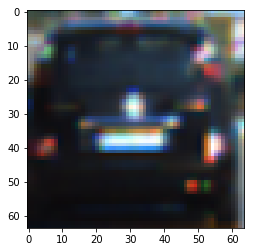

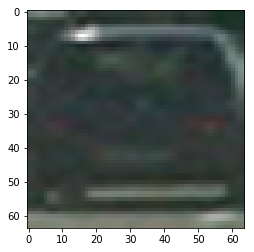

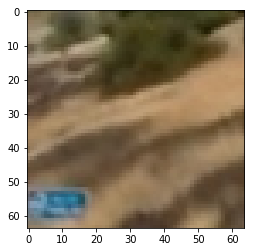

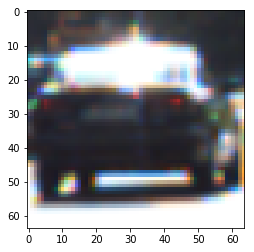

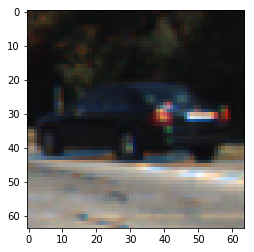

In [7]:
for file_name in np.random.choice(X_train_files_name, size=10, replace=False):
    plt.figure()
    plt.imshow(read_image(file_name))

# Select features

We are going to evaluate several image features using Linear SVM classiefier.

In [8]:
from skimage.feature import hog
import time

In [9]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    return hog(img, orientations=orient, 
                              pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), 
                              transform_sqrt=True,
                              block_norm='L2-Hys',
                              visualise=vis, feature_vector=feature_vec)

def get_color_hist(img, nbins=32):
    histograms = [np.histogram(img[:,:,i], bins=nbins) for i in range(img.shape[2])]
    histograms = [histogram[0] for histogram in histograms]
    return np.concatenate(histograms)

def get_color_space(image, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: return np.copy(image)  
    
def extract_features(imgs, color_space='RGB',
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = read_image(file)
        # apply color conversion if other than 'RGB'
        feature_image = get_color_space(image, color_space)

        if hist_feat == True:
            # Apply color_hist()
            hist_features = get_color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return np.array(features, dtype=np.float32)

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [11]:
color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV',  'YCrCb']
color_hist_results = {}
for color_space in color_spaces:
    t1 = time.time()
    X_train = extract_features(
        X_train_files_name, color_space,
        hist_bins=32, hist_feat=True, hog_feat=False
    )
    t2 = time.time()
    model = make_pipeline(StandardScaler(), LinearSVC(dual=False))
    t3 = time.time()
    score = np.mean(cross_val_score(model, X_train, Y_train, scoring='f1', n_jobs=-1))
    t4 = time.time()
    color_hist_results[color_space] = {
        "datset_size": list(X_train.shape),
        "f1": score,
        "get_feature_time": round(t2 - t1, 2),
        "validation_time": round(t4 - t3, 2),
    }    

In [12]:
print(color_hist_results)

{'YUV': {'datset_size': [14208, 96], 'f1': 0.90039148075816333, 'get_feature_time': 12.73, 'validation_time': 0.6}, 'YCrCb': {'datset_size': [14208, 96], 'f1': 0.9058451738658736, 'get_feature_time': 12.63, 'validation_time': 0.52}, 'RGB': {'datset_size': [14208, 96], 'f1': 0.8494170068052348, 'get_feature_time': 17.83, 'validation_time': 0.74}, 'HSV': {'datset_size': [14208, 96], 'f1': 0.92277243060096248, 'get_feature_time': 12.76, 'validation_time': 0.81}, 'LUV': {'datset_size': [14208, 96], 'f1': 0.91562975420760984, 'get_feature_time': 14.55, 'validation_time': 0.6}, 'HLS': {'datset_size': [14208, 96], 'f1': 0.91597475940472339, 'get_feature_time': 13.4, 'validation_time': 0.6}}


In [13]:
color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV',  'YCrCb']
hog_results = {}
for color_space in color_spaces:
    try:
        t1 = time.time()
        X_train = extract_features(X_train_files_name, color_space,
            hog_channel='ALL',
            hist_feat=False, hog_feat=True)
        t2 = time.time()
        model = make_pipeline(StandardScaler(), LinearSVC(dual=False))
        t3 = time.time()
        score = np.mean(cross_val_score(model, X_train, Y_train, scoring='f1', n_jobs=-1))
        t4 = time.time()
        hog_results[color_space] = {
            "datset_size": list(X_train.shape),
            "f1": score,
            "get_feature_time": round(t2 - t1, 2),
            "validation_time": round(t4 - t3, 2),
        }
    except:
        print("Error. Color space: {}".format(color_space))

In [14]:
print(hog_results)

{'YUV': {'datset_size': [14208, 5292], 'f1': 0.9641530661435852, 'get_feature_time': 110.14, 'validation_time': 15.87}, 'YCrCb': {'datset_size': [14208, 5292], 'f1': 0.963232982023698, 'get_feature_time': 109.61, 'validation_time': 15.97}, 'RGB': {'datset_size': [14208, 5292], 'f1': 0.92354902983587517, 'get_feature_time': 102.99, 'validation_time': 411.53}, 'HSV': {'datset_size': [14208, 5292], 'f1': 0.94730721942650919, 'get_feature_time': 115.56, 'validation_time': 102.83}, 'LUV': {'datset_size': [14208, 5292], 'f1': 0.96398380851466392, 'get_feature_time': 116.83, 'validation_time': 14.14}, 'HLS': {'datset_size': [14208, 5292], 'f1': 0.9492067149692397, 'get_feature_time': 112.15, 'validation_time': 115.07}}


I discarded RGB color space, for its undesirable properties under changing light conditions. I deside to use HSV sapce for color features and HLS space for shape features.

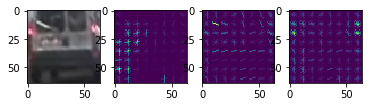

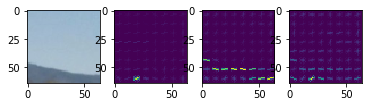

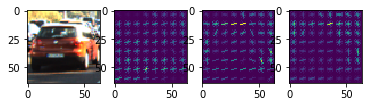

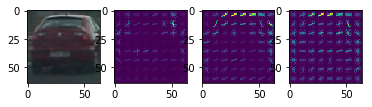

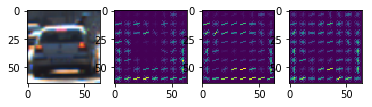

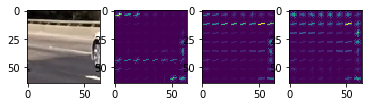

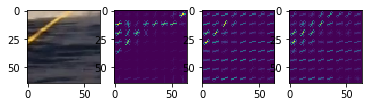

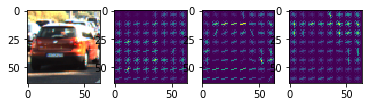

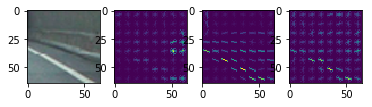

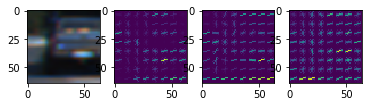

In [15]:
for file_name in np.random.choice(X_train_files_name, size=10, replace=False):
    img = read_image(file_name)
    plt.figure()
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    hog_img = get_color_space(img, 'HLS')
    for channel in range(hog_img.shape[2]):
        _, hog_img_for_channel = get_hog_features(hog_img[:, :, channel], 9, 8, 2, 
                        vis=True, feature_vec=True)
        plt.subplot(1, 4, channel + 2)
        plt.imshow(hog_img_for_channel)

In [16]:
def get_feature(files_name):
    color_features = extract_features(files_name, 'HSV',
                        hist_bins=32, hist_feat=True, hog_feat=False)
    hog_features = extract_features(files_name, 'HLS',
                        hog_channel='ALL', hist_feat=False, hog_feat=True)
    return np.concatenate([color_features, hog_features], axis=1)

In [17]:
X_train = get_feature(X_train_files_name)

In [18]:
X_test = get_feature(X_test_files_name)

In [19]:
np.save('./checkpoints/features_data', (X_train, X_test))

In [20]:
X_train, Y_train = shuffle(X_train, Y_train)

# Train liner svm

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

In [22]:
parameters = [{'linearsvc__C': [1, 10]}]
model = make_pipeline(StandardScaler(), LinearSVC(dual=False))

In [23]:
clf = GridSearchCV(model, parameters, n_jobs = 2, scoring=['f1', 'accuracy'], refit='f1')

In [24]:
clf.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearsvc', LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=2,
       param_grid=[{'linearsvc__C': [1, 10]}], pre_dispatch='2*n_jobs',
       refit='f1', return_train_score=True, scoring=['f1', 'accuracy'],
       verbose=0)

In [25]:
clf.cv_results_

{'mean_fit_time': array([ 26.45592602,  25.15890574]),
 'mean_score_time': array([ 0.65327907,  0.59926693]),
 'mean_test_accuracy': array([ 0.97642173,  0.97663288]),
 'mean_test_f1': array([ 0.97634371,  0.97655397]),
 'mean_train_accuracy': array([ 1.,  1.]),
 'mean_train_f1': array([ 1.,  1.]),
 'param_linearsvc__C': masked_array(data = [1 10],
              mask = [False False],
        fill_value = ?),
 'params': [{'linearsvc__C': 1}, {'linearsvc__C': 10}],
 'rank_test_accuracy': array([2, 1], dtype=int32),
 'rank_test_f1': array([2, 1], dtype=int32),
 'split0_test_accuracy': array([ 0.97635135,  0.97635135]),
 'split0_test_f1': array([ 0.97631134,  0.97631134]),
 'split0_train_accuracy': array([ 1.,  1.]),
 'split0_train_f1': array([ 1.,  1.]),
 'split1_test_accuracy': array([ 0.97740709,  0.97740709]),
 'split1_test_f1': array([ 0.97730647,  0.97730647]),
 'split1_train_accuracy': array([ 1.,  1.]),
 'split1_train_f1': array([ 1.,  1.]),
 'split2_test_accuracy': array([ 0.97550

Linear SVM achieve similar results no matter the C parameter(f-socore of 96%), better results could be achive with spatial features and rbf kernel. 

In [26]:
model = clf.best_estimator_

In [27]:
from sklearn.metrics import f1_score, accuracy_score

In [28]:
predictions = model.predict(X_test)
print(f1_score(predictions, Y_test))
print(accuracy_score(predictions, Y_test))

0.977272727273
0.976914414414


In [29]:
from sklearn.externals import joblib

In [30]:
joblib.dump(model, 'model.pkl') 

['model.pkl']